In [1]:
#imports
import matplotlib.pyplot as plt 
from numpy import errstate,isneginf,array
from pydotplus import graph_from_dot_data
from IPython.display import Image  
import seaborn as sns
from IPython.display import HTML, display
import tabulate
import numpy as np
import pandas as pd
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import log_loss
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

load_local=False
#load_local=True
downsample=False

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## loading data from google drive. At the end of this section is the loading for local execution

In [2]:

if(load_local==False):
  #load data from google drive
  !pip install -U -q PyDrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  from google.colab import drive
  # Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)


  link = 'https://drive.google.com/open?id=1sAWX8yc9LUALOdiEFNhTDu6FjMDVOoKQ' # The shareable link
  fluff, id = link.split('=')
  print (id) # Verify that you have everything after '='
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('accidents.csv')  
  train = pd.read_csv('accidents.csv')
  # Dataset is now stored in a Pandas Dataframe


  link2 = 'https://drive.google.com/open?id=1Q680aDtN8P0o32MgIa1Yq3WN4cK8jHgi' # The shareable link
  fluff2, id2 = link2.split('=')
  print (id2) # Verify that you have everything after '='
  downloaded = drive.CreateFile({'id':id2}) 
  downloaded.GetContentFile('vehicles.csv')  
  vehicle_init = pd.read_csv('vehicles.csv')
  # Dataset is now stored in a Pandas Dataframe

  link3 = 'https://drive.google.com/open?id=1EiA6CocegLyXA5ihjlvnGpFCYmj4AqGz' # The shareable link
  fluff3, id3 = link3.split('=')
  print (id3) # Verify that you have everything after '='
  downloaded = drive.CreateFile({'id':id3}) 
  downloaded.GetContentFile('test.csv')  
  test = pd.read_csv('test.csv')
  # Dataset is now stored in a Pandas Dataframe
else:
  train = pd.read_csv('accidents.csv')
  test = pd.read_csv('test.csv')
  vehicles_init = pd.read_csv('vehicles.csv')  

1sAWX8yc9LUALOdiEFNhTDu6FjMDVOoKQ
1Q680aDtN8P0o32MgIa1Yq3WN4cK8jHgi
1EiA6CocegLyXA5ihjlvnGpFCYmj4AqGz


In [0]:
#create target variable for the test set
test["target"]=-1

## FE: Calculate district risk factor

In [0]:
#calculate district risk factor
##total counts district 
total_district_count=train["local_authority_district"].value_counts()
df_o = pd.DataFrame()
df_o["value"]=total_district_count
df_o['name'] = total_district_count.index
##severe counts in district
positive_district=train.local_authority_district.loc[train.target==1]
severe_district_count=positive_district.value_counts()
df_pos = pd.DataFrame()
df_pos["value"]=severe_district_count
df_pos['name'] = severe_district_count.index
##calculate risk factor = severe/total
risk_district_table = pd.DataFrame()
for district in df_pos['name']:
    total=df_o["value"].loc[df_o["name"] == district][0]
    sev=df_pos["value"].loc[df_pos["name"] == district][0]
    risk=sev/total
    risk_district_table = risk_district_table.append({'district': district, 'severe': sev, 'total': total, 'risk_factor': risk}, ignore_index=True)
#replace local_authority_district in train and test set with  risk factor   
train.local_authority_district=train.local_authority_district.replace(dict(zip(risk_district_table.district, risk_district_table.risk_factor)))
test.local_authority_district=test.local_authority_district.replace(dict(zip(risk_district_table.district, risk_district_table.risk_factor)))

In [5]:
risk_district_table.head()

,district,risk_factor,severe,total
0,Birmingham,0.159801,450.0,2816.0
1,Leeds,0.161954,315.0,1945.0
2,Cornwall,0.223967,271.0,1210.0
3,Liverpool,0.220532,232.0,1052.0
4,Wiltshire,0.193868,215.0,1109.0


## Merging of test, accidents and drivers with following feature engeneering on whole data set

In [0]:
#whole dataset for feature level extraction
total=train
total = total.append(test)
total_entries_train=len(train)

In [0]:
#labelencoder for predetermined cateogirical variables
le = LabelEncoder()

total["pedestrian_crossing-physical_facilities"]= le.fit_transform(total["pedestrian_crossing-physical_facilities"])
total["light_conditions"]= le.fit_transform(total["light_conditions"])
total["weather_conditions"] = le.fit_transform(total["weather_conditions"])
total["road_surface_conditions"] = le.fit_transform(total["road_surface_conditions"])
total["pedestrian_crossing-human_control"] = le.fit_transform(total["pedestrian_crossing-human_control"])
total["road_type"] = le.fit_transform(total["road_type"])


In [0]:
pd.options.mode.chained_assignment = None 
#merging whole dataset with drivers.csv
total_merge = total.merge(vehicle_init, on="accident_id", how='outer')
accident_id_train=train["accident_id"]
accident_id_test=test["accident_id"]

In [0]:
#hour and day cyclic encoding
total=total_merge
total['date'] = pd.to_datetime(total['date'], dayfirst=True)
total['weekday'] = total['date'].dt.weekday_name
total['month'] = total['date'].dt.month
total['day'] = total['date'].dt.day
total['time'] = pd.to_datetime(total['time'])
total['hour'] = total['time'].dt.hour
total['minute'] = total['time'].dt.minute
del total['time']
del total['date']
total['hourfloat']=total.hour+total.minute/60.0
total['x_hour']=np.sin(2.*np.pi*total.hourfloat/24.)
total['y_hour']=np.cos(2.*np.pi*total.hourfloat/24.)
total['x_day']=np.sin(2.*np.pi*total.day/31.)
total['y_day']=np.cos(2.*np.pi*total.day/31.)
del total['hour']
del total['hourfloat']
del total['minute']
del total['day']
#total.head()

In [0]:
#avoiding -1 values and log transformation;needs to be optimized
total['Age_of_Driver'][total['Age_of_Driver'] < 0.1] = 1
total['Age_of_Vehicle'][total['Age_of_Vehicle'] < 0.1] = 1
total['Age_of_Driver'] = np.log(total['Age_of_Driver'])
total['Age_of_Vehicle'] = np.log(total['Age_of_Vehicle'])

## one-hot-encoding on whole merged dataset for pre evaluated features

In [11]:
accident_ml_total = total
accident_ml_total = accident_ml_total[["target","accident_id",'number_of_casualties','2nd_road_number' ,"longitude",	"latitude", 'Age_of_Driver' ,"speed_limit","local_authority_district","Vehicle_Type","Vehicle_Manoeuvre","Sex_of_Driver","Engine_Capacity_(CC)","weekday","x_hour","y_hour",	"x_day",	"y_day"]]
accident_ml_total[accident_ml_total==np.inf]=np.nan
accident_ml_total=accident_ml_total.fillna(0)

#one-hot-encode
one_hot_columns=[
                 "Vehicle_Manoeuvre"
                 #, "road_type"
                 #,'weather_conditions'
                 ,'speed_limit'
                 ,'Vehicle_Type'
                 ,"Sex_of_Driver"
                 ,"weekday"
                 #,"urban_or_rural_area"
                ]
for column_encode in one_hot_columns:
    print(column_encode," encoded")
    one_hot = pd.get_dummies(accident_ml_total[column_encode]).add_prefix(column_encode)
    accident_ml_total = accident_ml_total.drop(column_encode,axis = 1)
    # Join the encoded df
    accident_ml_total = accident_ml_total.join(one_hot)

Vehicle_Manoeuvre  encoded
speed_limit  encoded
Vehicle_Type  encoded
Sex_of_Driver  encoded
weekday  encoded


# Prepare train set

In [0]:
accident_ml=accident_ml_total[accident_ml_total.accident_id.isin(accident_id_train)]
y=accident_ml_total.target[accident_ml_total.accident_id.isin(accident_id_train)]
accident_ml_final=accident_ml
#downsample=False
del accident_ml_final["target"]
del accident_ml_final["accident_id"]


In [0]:
#train eval split
X_train, X_test, y_train, y_test = train_test_split(accident_ml_final, y, test_size=0.2, random_state=99)


if (downsample==True):
  X_train["target"]=y_train
  severe = X_train[X_train.target==1]
  normal = X_train[X_train.target==0]


  from sklearn.utils import resample

  normal_downsampled = resample(normal,
                                  replace = False, # sample without replacement
                                  n_samples = len(severe), # match minority n
                                  random_state = 27) # reproducible results

  # combine minority and downsampled majority
  downsampled = pd.concat([normal_downsampled, severe])

  # checking counts
  downsampled.target.value_counts()
  y=downsampled.target
  del downsampled["target"]
  #del downsampled["accident_id"]
  X_train=downsampled
  y_train=y


#check for nan or inf values before training
X_train[X_train==np.inf]=np.nan
X_train=X_train.fillna(0)
X_test[X_test==np.inf]=np.nan
X_test=X_test.fillna(0)
y_train[y_train==np.inf]=np.nan
y_train=y_train.fillna(0)

# model training with validation set

In [14]:
#predict based on random forest
random_forest = RandomForestClassifier(n_estimators=200)
random_forest.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:

x_result_train=X_test
Y_pred = random_forest.predict(X_test)
random_forest.score(X_test, y_test)
acc_random_forest1 = round(random_forest.score(X_test, y_test) * 100, 2)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=Y_pred)
print("Accuracy" , acc_random_forest1)
print(sk_report)
pd.crosstab(y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Accuracy 85.53
              precision    recall  f1-score   support

         0.0   0.855798  0.995407  0.920338     43106
         1.0   0.835411  0.122040  0.212969      8235

    accuracy                       0.855320     51341
   macro avg   0.845605  0.558723  0.566653     51341
weighted avg   0.852528  0.855320  0.806877     51341



Predicted,0.0,1.0,All
Actual,,,
0.0,42908,198,43106
1.0,7230,1005,8235
All,50138,1203,51341


## Note: Next training takes a while for the grid search in case the data is not downsampled

In [16]:
random_forest.get_params()
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100],
    'max_features': [4, 5],
    'min_samples_leaf': [5, 10],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200]
}
# Create a based model
random_f = RandomForestClassifier()
# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = random_f, param_distributions = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 15.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

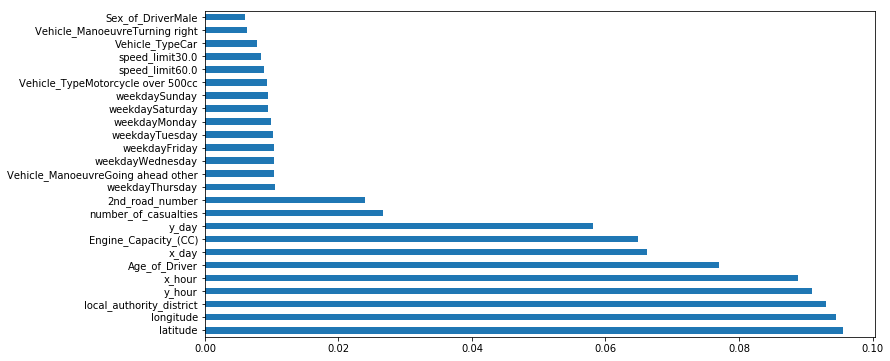

In [17]:
plt.figure(figsize=(12,6))
feat_importances = pd.Series(random_forest.feature_importances_, index=accident_ml_final.columns)
feat_importances.nlargest(25).plot(kind='barh')

In [0]:
#gradient boost
#from xgboost import XGBClassifier
#model = XGBClassifier()
#model.fit(X_train, y_train)

# make predictions for test data
#y_pred = model.predict(X_test)
#predictions = [round(value) for value in y_pred]
#accuracy = accuracy_score(y_test, predictions)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Test prediciton

In [0]:
test_1=accident_ml_total[accident_ml_total.accident_id.isin(accident_id_test)].copy()
test_1[test_1==np.inf]=np.nan
test_1=test_1.fillna(0)
#back to train and test set
del test_1["target"]
test_1_backup=test_1.copy()
del test_1_backup["accident_id"]
y_pred_submit_rf =grid_search.predict(test_1_backup)
Y_pred = random_forest.predict(test_1_backup)


#y_pred_submit_xgb = model.predict(test_1_backup)


# groupby account_id and sum over y_pred

In [0]:
test_1_result=test_1.copy()

test_1_result["y_pred"]=-1
array = np.array(Y_pred)
test_1_result["y_pred"]=array
test_1_result = test_1_result.groupby(test_1_result.accident_id, as_index=False).agg({'accident_id': 'first',
                                #'Transaction': 'first',
                                'y_pred':sum})

# Note: The following process takes some time. A mapping was not possible with my RAM, so I had to make it a bit more computational complex

In [0]:
test_eval=test.copy()
test_eval["y_pred"]=-1
test_eval = test_eval[['accident_id','y_pred']]

for index, row in test_1_result.iterrows():
    #print(int(row['accident_id']), int(row['y_pred']))
    test_eval.y_pred.loc[test_eval['accident_id']==int(row['accident_id'])] =int(row['y_pred'])


In [0]:
#set classified target to 1 in case a severity was predicted inside the 1:n
test_eval2=test_eval.copy()
test_eval2.loc[test_eval2['y_pred'] > 0.9, 'y_pred'] = 1

In [23]:
test_eval2.y_pred.describe()

count    129950.000000
mean          0.019177
std           0.137146
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: y_pred, dtype: float64

In [24]:
print(test_eval2["y_pred"])

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
129920    0
129921    0
129922    0
129923    1
129924    0
129925    0
129926    0
129927    0
129928    0
129929    0
129930    0
129931    0
129932    0
129933    0
129934    0
129935    0
129936    0
129937    0
129938    0
129939    0
129940    0
129941    0
129942    0
129943    0
129944    0
129945    0
129946    0
129947    0
129948    0
129949    0
Name: y_pred, Length: 129950, dtype: int64


In [25]:
#save to drive
if(load_local==False):
  drive.mount('drive')
  test_eval2["y_pred"].to_csv('submission_tuned_sampled.csv', index=False)
  !cp submission_tuned_sampled.csv drive/My\ Drive/
  test_eval2.to_csv('submission_tuned_sampled_full.csv', index=False)
  !cp submission_tuned_sampled_full.csv drive/My\ Drive/

AttributeError: ignored